In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20230525.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20211227.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A19810224.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20231009.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20210120.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A19810408.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20190310.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20221002.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20240419.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20221226.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A19790527.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A20190119.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A19790902.png
/kaggle/input/water-scarcity/visualization_outputUp/Evap/A19790315.png
/kaggl

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay
from PIL import Image
from tqdm import tqdm

2025-04-27 23:07:42.783600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745795263.260042      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745795263.403294      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
FEATURES = ['Evap', 'Rainf', 'RootMoist', 'SoilM_0_10cm', 'TVeg']
BASE_PATH = "/kaggle/input/water-scarcity/visualization_outputUp"  # Update this path to your data location
IMG_SIZE = (176, 260)  # Adjust based on your actual image dimensions
BATCH_SIZE = 32  # Larger batches for better GPU utilization
EPOCHS = 50
RANDOM_SEED = 42

In [4]:
try:
    import nvidia_smi
    NVIDIA_SMI_AVAILABLE = True
except ImportError:
    NVIDIA_SMI_AVAILABLE = False
    print("nvidia-smi not available. GPU monitoring disabled.")


nvidia-smi not available. GPU monitoring disabled.


In [5]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
def setup_gpu():
    physical_devices = tf.config.list_physical_devices('GPU')
    for device in physical_devices:
        try:
            tf.config.experimental.set_memory_growth(device, True)
        except RuntimeError as e:
            print(f"Error setting memory growth: {e}")

In [7]:
import tensorflow as tf

# List all physical GPU devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Print which device is used
if tf.test.gpu_device_name():
    print("TensorFlow is using GPU:", tf.test.gpu_device_name())
else:
    print("TensorFlow is NOT using the GPU.")


Num GPUs Available:  2
TensorFlow is using GPU: /device:GPU:0


I0000 00:00:1745795283.730681      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745795283.731479      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1745795283.734298      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745795283.734528      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
def load_images_from_folder(folder_path, img_size):
    """Load and preprocess images from a folder"""
    images = []
    filenames = []
    
    print(f"Loading images from {folder_path}...")
    for filename in tqdm(sorted(os.listdir(folder_path))):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('L')  # grayscale
            img = img.resize((img_size[1], img_size[0]))  # (width, height)
            images.append(np.array(img) / 255.0)  # Normalize
            filenames.append(filename)
            
    return np.array(images), filenames


In [9]:
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(inputs, decoded)
    return autoencoder


In [10]:
def spatial_attention_block(input_tensor):
    """Add spatial attention to focus on important regions"""
    # Use Lambda layers to wrap TensorFlow operations
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)
    concat = layers.Concatenate()([avg_pool, max_pool])
    attention = layers.Conv2D(1, 7, activation='sigmoid', padding='same')(concat)
    return layers.Multiply()([input_tensor, attention])

In [11]:
def build_attention_autoencoder(input_shape):
    """Autoencoder with spatial attention mechanism that preserves dimensions exactly"""
    inputs = layers.Input(shape=input_shape)
    
    # Store original dimensions
    h, w, c = input_shape
    
    # Encoder with attention
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = spatial_attention_block(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = spatial_attention_block(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    
    # Final layer with cropping/padding to ensure exact dimension match
    x = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    # Add a Lambda layer to resize to exact input dimensions
    decoded = layers.Lambda(
        lambda x: tf.image.resize(x, [h, w])
    )(x)
    
    return models.Model(inputs, decoded)

sta3melt autoencoder hna (convolutional auto encoder CAU) khater maandich labels donc sta3meltou bch yreconstructy el input images mta3y, ken famma noise yreducih w bch yaaml highlit lel key spacial patterns, bch baad najjem naaml analyse lel tsawer

In [12]:
def visualize_reconstruction(original, reconstructed, n=5):
    """Visualize original and reconstructed images side by side"""
    plt.figure(figsize=(15, 5))
    for i in range(min(n, len(original))):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [13]:
def detect_anomalies(autoencoder, images, threshold_quantile=0.95):
    """Detect anomalies based on reconstruction error"""
    print("Detecting anomalies...")
    reconstructions = autoencoder.predict(images, verbose=0)
    # Calculate per-pixel error
    pixel_errors = np.square(images - reconstructions)
    # Calculate per-image error
    image_errors = np.mean(pixel_errors, axis=(1, 2, 3))
    # Determine threshold
    threshold = np.quantile(image_errors, threshold_quantile)
    return pixel_errors, image_errors, threshold


In [14]:
def visualize_anomalies(images, pixel_errors, image_errors, threshold, n=5):
    """Visualize images with anomaly heatmaps"""
    plt.figure(figsize=(20, 10))
    
    # Select n images with highest error
    highest_error_indices = np.argsort(image_errors)[-n:]
    
    for i, idx in enumerate(highest_error_indices):
        # Original image
        plt.subplot(2, n, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f"Original (idx: {idx})")
        plt.axis('off')
        
        # Anomaly heatmap
        plt.subplot(2, n, i+1+n)
        plt.imshow(np.mean(pixel_errors[idx], axis=-1), cmap='hot', alpha=0.7)
        plt.colorbar()
        plt.title(f"Error: {image_errors[idx]:.4f}")
        plt.axis('off')
    
    plt.suptitle(f"Threshold: {threshold:.4f}")
    plt.tight_layout()
    plt.show()

In [15]:
def cluster_anomalies(features, n_clusters=3, visualize=True):
    """Cluster features and visualize results using t-SNE"""
    print(f"Clustering data into {n_clusters} clusters...")
    
    # Flatten features if needed
    if len(features.shape) > 2:
        features_flat = features.reshape(features.shape[0], -1)
    else:
        features_flat = features
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
    clusters = kmeans.fit_predict(features_flat)
    
    # Visualization with t-SNE
    if visualize and features_flat.shape[1] > 2:
        print("Performing t-SNE dimensionality reduction...")
        tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
        reduced = tsne.fit_transform(features_flat)
        
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, 
                             cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Cluster')
        plt.title('t-SNE Visualization of Drought Patterns')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.show()
    
    return clusters


In [16]:
def visualize_clusters(X, anomalous_indices, clusters):
    """Visualize representative samples from each cluster"""
    n_clusters = len(np.unique(clusters))
    
    plt.figure(figsize=(15, 5))
    for cluster_id in range(n_clusters):
        # Get cluster samples
        cluster_samples_idx = np.where(clusters == cluster_id)[0]
        cluster_samples = X[anomalous_indices][cluster_samples_idx]
        n_samples = len(cluster_samples)
        
        # Plot up to 3 samples per cluster
        for i, sample_idx in enumerate(cluster_samples_idx[:3]):
            plt.subplot(n_clusters, 3, cluster_id * 3 + i + 1)
            plt.imshow(X[anomalous_indices[sample_idx]].squeeze(), cmap='gray')
            plt.title(f"Cluster {cluster_id}\n({n_samples} samples)")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [17]:
def approximate_ndvi_from_grayscale(images):
    """Approximate NDVI values from grayscale (for demonstration)"""
    # This is just a placeholder since we don't have true NDVI data
    # In reality, NDVI requires NIR and Red bands
    print("Approximating NDVI values from grayscale...")
    pseudo_ndvi = 2 * images.squeeze() - 1  # Scale [0,1] to [-1,1]
    return pseudo_ndvi

def validate_with_ndvi(autoencoder, images, ndvi_maps):
    """Validate anomaly detection against NDVI values"""
    print("Validating with NDVI...")
    # Get reconstruction errors
    reconstructions = autoencoder.predict(images, verbose=0)
    errors = np.mean(np.square(images - reconstructions), axis=(1, 2, 3))
    
    # Calculate mean NDVI per image
    mean_ndvi = ndvi_maps.mean(axis=(1, 2))
    
    # Calculate correlation
    correlation = np.corrcoef(mean_ndvi, errors)[0, 1]
    
    # Visualization
    plt.figure(figsize=(10, 5))
    plt.scatter(mean_ndvi, errors, alpha=0.6)
    plt.xlabel('Mean NDVI')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Correlation: {correlation:.2f}')
    plt.grid()
    plt.show()
    
    return correlation

In [18]:
def overlay_validation(images, ndvi, pixel_errors, img_indices):
    """Side-by-side comparison of original image, NDVI and anomaly detection"""
    for img_idx in img_indices:
        plt.figure(figsize=(15, 5))
        
        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[img_idx].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # NDVI Map
        plt.subplot(1, 3, 2)
        plt.imshow(ndvi[img_idx], cmap='RdYlGn', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title(f"NDVI Map (Mean: {ndvi[img_idx].mean():.2f})")
        plt.axis('off')
        
        # Anomaly Map
        plt.subplot(1, 3, 3)
        plt.imshow(np.mean(pixel_errors[img_idx], axis=-1), cmap='hot')
        plt.colorbar()
        plt.title("Reconstruction Error")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


In [19]:
def evaluate_with_ndvi_threshold(image_errors, ndvi_maps, ndvi_threshold=0.3):
    """Evaluate anomaly detection using NDVI-based 'ground truth'"""
    print(f"Evaluating using NDVI threshold of {ndvi_threshold}...")
    
    # Create NDVI-based labels (1=drought, 0=healthy)
    ndvi_mean = ndvi_maps.mean(axis=(1, 2))
    ndvi_labels = (ndvi_mean < ndvi_threshold).astype(int)
    
    # Find optimal error threshold (Youden's J statistic)
    fpr, tpr, thresholds = roc_curve(ndvi_labels, image_errors)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Metrics
    predictions = (image_errors > optimal_threshold).astype(int)
    print(classification_report(ndvi_labels, predictions))
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    
    # Plot ROC curve
    RocCurveDisplay.from_predictions(ndvi_labels, image_errors)
    plt.show()
    
    return optimal_threshold

In [20]:
def process_new_image(img_path, autoencoder, threshold):
    """Process a new image for drought detection"""
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_SIZE[1], IMG_SIZE[0]))  # width, height
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))
    
    reconstruction = autoencoder.predict(img_array, verbose=0)
    error = np.mean((img_array - reconstruction) ** 2)
    
    is_drought = error > threshold
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0].squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(reconstruction[0].squeeze(), cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.square(img_array[0] - reconstruction[0]).squeeze(), cmap='hot')
    plt.colorbar()
    plt.title(f"Error: {error:.4f}\nThreshold: {threshold:.4f}")
    plt.axis('off')
    
    plt.suptitle(f"Drought Detected: {'YES' if is_drought else 'NO'}", 
                fontsize=16, color='red' if is_drought else 'green')
    plt.tight_layout()
    plt.show()
    
    return is_drought, error


In [21]:
def find_optimal_clusters(features, max_k=10):
    """Find optimal number of clusters using elbow method"""
    print("Finding optimal number of clusters...")
    distortions = []
    K_range = range(1, max_k + 1)
    for k in tqdm(K_range):
        kmeans_model = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans_model.fit(features)
        distortions.append(kmeans_model.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method for Optimal k')
    plt.grid()
    plt.show()
    
    # Calculate rate of change to find elbow point
    changes = np.diff(distortions)
    changes_ratio = changes[1:] / changes[:-1]
    elbow_point = np.argmin(changes_ratio) + 2  # +2 because of offset
    
    print(f"Suggested optimal number of clusters: {elbow_point}")
    return elbow_point


In [22]:
def analyze_drought_patterns(feature_name):
    """Complete drought pattern analysis pipeline for a single feature"""
    print(f"\n{'='*20} Processing {feature_name} {'='*20}")
    
    # 1. Setup
    setup_gpu()
    
    # 2. Load Data
    folder_path = os.path.join(BASE_PATH, feature_name)
    X, filenames = load_images_from_folder(folder_path, IMG_SIZE)
    X = np.expand_dims(X, -1)  # Add channel dimension
    print(f"Loaded {X.shape[0]} images for {feature_name}")
    
    # 3. Split data
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=RANDOM_SEED)
    print(f"Training set: {X_train.shape[0]}, Test set: {X_test.shape[0]}")
    
    # 4. Build and train model
    print("Building and training autoencoder...")
    autoencoder = build_attention_autoencoder((*IMG_SIZE, 1))
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    # Train with callbacks for early stopping and model checkpointing
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
    
    history = autoencoder.fit(
        X_train, X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(X_test, X_test),
        callbacks=callbacks,
        verbose=1
    )
    
    # 5. Visualize training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if 'lr' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Visualize some reconstructions
    print("Generating reconstructions...")
    decoded_imgs = autoencoder.predict(X_test[:10], verbose=0)
    visualize_reconstruction(X_test[:10], decoded_imgs)
    
    # 7. Extract latent features (encoder output)
    print("Extracting latent features...")
    encoder = models.Model(autoencoder.input, autoencoder.layers[4].output)
    encoded_features = encoder.predict(X, verbose=0)
    
    # Get flattened features for clustering
    features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
    
    # 8. Detect anomalies
    pixel_errors, image_errors, threshold = detect_anomalies(autoencoder, X)
    visualize_anomalies(X, pixel_errors, image_errors, threshold)
    
    # 9. Get anomalous indices
    anomalous_indices = np.where(image_errors > threshold)[0]
    print(f"Found {len(anomalous_indices)} potential drought areas")
    
    # 10. Find optimal number of clusters (if we have enough anomalies)
    if len(anomalous_indices) >= 10:
        optimal_k = find_optimal_clusters(features_flat[anomalous_indices])
    else:
        optimal_k = min(len(anomalous_indices), 3)
        print(f"Too few anomalies, using k={optimal_k}")
    
    # 11. Cluster anomalies
    anomalous_features = features_flat[anomalous_indices]
    clusters = cluster_anomalies(anomalous_features, n_clusters=optimal_k)
    
    # 12. Visualize clusters
    visualize_clusters(X, anomalous_indices, clusters)
    
    # 13. Optional: NDVI validation
    print("Generating approximate NDVI for validation...")
    # This is a placeholder since we don't have true NDVI data
    pseudo_ndvi = approximate_ndvi_from_grayscale(X)
    
    # Validate anomaly detection against NDVI
    correlation = validate_with_ndvi(autoencoder, X, pseudo_ndvi)
    
    # Show side-by-side comparisons for a few samples
    overlay_validation(X, pseudo_ndvi, pixel_errors, 
                      anomalous_indices[:3])  # Show first 3 anomalies
    
    # 14. Evaluate against NDVI threshold
    eval_threshold = evaluate_with_ndvi_threshold(image_errors, pseudo_ndvi)
    
    # 15. Return the model and threshold for later use
    return autoencoder, threshold, eval_threshold, anomalous_indices, clusters


In [23]:
def find_optimal_clusters(features, max_k=10):
    """Find optimal number of clusters using elbow method"""
    print("Finding optimal number of clusters...")
    distortions = []
    K_range = range(1, max_k + 1)
    for k in tqdm(K_range):
        kmeans_model = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans_model.fit(features)
        distortions.append(kmeans_model.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method for Optimal k')
    plt.grid()
    plt.show()
    
    # Calculate rate of change to find elbow point
    changes = np.diff(distortions)
    changes_ratio = changes[1:] / changes[:-1]
    elbow_point = np.argmin(changes_ratio) + 2  # +2 because of offset
    
    print(f"Suggested optimal number of clusters: {elbow_point}")
    return elbow_point

In [24]:
import gc
def analyze_drought_patterns(feature_name):
    """Drought pattern analysis with memory management"""
    print(f"\n{'='*20} Processing {feature_name} {'='*20}")
    
    # 1. Load Data (smaller batch)
    folder_path = os.path.join(BASE_PATH, feature_name)
    X, filenames = load_images_from_folder(folder_path, IMG_SIZE)
    X = np.expand_dims(X, -1)  # Add channel dimension
    print(f"Loaded {X.shape[0]} images for {feature_name}")
    
    # Print memory usage information
    print(f"Dataset shape: {X.shape}, Memory usage: {X.nbytes / (1024**2):.2f} MB")
    
    # 2. Split data
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=RANDOM_SEED)
    
    # 3. Build a simpler model (reduce complexity)
    print("Building simpler autoencoder...")
    input_shape = (*IMG_SIZE, 1)
    
    # Simpler autoencoder model
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder (reduced filters)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder (matching encoder)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = tf.keras.models.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    # 4. Train with smaller batch size
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
    
    # Smaller batch size
    batch_size = 4  # Try a much smaller batch
    
    try:
        history = autoencoder.fit(
            X_train, X_train,
            epochs=EPOCHS,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(X_test, X_test),
            callbacks=callbacks,
            verbose=1
        )
        print("Training completed successfully")
    except Exception as e:
        print(f"Error during training: {e}")
        return None, None, None, None, None
    
    # Clear memory after training
    tf.keras.backend.clear_session()
    gc.collect()
    
    # 5. Detect anomalies in batches
    print("Detecting anomalies in batches...")
    batch_size = 4
    n_samples = X.shape[0]
    reconstructed_chunks = []
    
    # Process in chunks to avoid memory issues
    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        chunk = X[i:end_idx]
        reconstructed_chunk = autoencoder.predict(chunk, verbose=0)
        reconstructed_chunks.append(reconstructed_chunk)
    
    reconstructed_images = np.concatenate(reconstructed_chunks, axis=0)
    pixel_errors = np.abs(X - reconstructed_images)
    image_errors = np.mean(pixel_errors, axis=(1, 2, 3))
    threshold = np.mean(image_errors) + 2 * np.std(image_errors)
    
    # Get anomalous indices
    anomalous_indices = np.where(image_errors > threshold)[0]
    
    # Simple clustering (reduced complexity)
    n_clusters = min(3, len(anomalous_indices))
    clusters = np.zeros(len(anomalous_indices), dtype=int)
    
    # Return results
    eval_threshold = threshold  # Simplified
    return autoencoder, threshold, eval_threshold, anomalous_indices, clusters

In [25]:
def process_new_image(img_path, autoencoder, threshold):
    img = Image.open(img_path).convert('L')
    img = img.resize(IMG_SIZE[::-1])
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))
    
    reconstruction = autoencoder.predict(img_array)
    error = np.mean((img_array - reconstruction) ** 2)
    
    if error > threshold:
        print("Drought-prone area detected!")
        return True, error
    return False, error

In [26]:
def analyze_drought_patterns(feature_name):
    """Complete drought pattern analysis pipeline for a single feature"""
    print(f"\n{'='*20} Processing {feature_name} {'='*20}")
    
    # 1. Setup
    setup_gpu()
    
    # 2. Load Data
    folder_path = os.path.join(BASE_PATH, feature_name)
    X, filenames = load_images_from_folder(folder_path, IMG_SIZE)
    X = np.expand_dims(X, -1)  # Add channel dimension
    print(f"Loaded {X.shape[0]} images for {feature_name}")
    
    # 3. Split data
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=RANDOM_SEED)
    print(f"Training set: {X_train.shape[0]}, Test set: {X_test.shape[0]}")
    
    # 4. Build and train model
    print("Building and training autoencoder...")
    autoencoder = build_attention_autoencoder((*IMG_SIZE, 1))
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    # Train with callbacks for early stopping and model checkpointing
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
    
    history = autoencoder.fit(
        X_train, X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(X_test, X_test),
        callbacks=callbacks,
        verbose=1
    )
    
    # 5. Visualize training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if 'lr' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Visualize some reconstructions
    print("Generating reconstructions...")
    decoded_imgs = autoencoder.predict(X_test[:10], verbose=0)
    visualize_reconstruction(X_test[:10], decoded_imgs)
    
    # 7. Extract latent features (encoder output)
    print("Extracting latent features...")
    encoder = models.Model(autoencoder.input, autoencoder.layers[4].output)
    encoded_features = encoder.predict(X, verbose=0)
    
    # Get flattened features for clustering
    features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
    
    # 8. Detect anomalies
    pixel_errors, image_errors, threshold = detect_anomalies(autoencoder, X)
    visualize_anomalies(X, pixel_errors, image_errors, threshold)
    
    # 9. Get anomalous indices
    anomalous_indices = np.where(image_errors > threshold)[0]
    print(f"Found {len(anomalous_indices)} potential drought areas")
    
    # 10. Find optimal number of clusters (if we have enough anomalies)
    if len(anomalous_indices) >= 10:
        optimal_k = find_optimal_clusters(features_flat[anomalous_indices])
    else:
        optimal_k = min(len(anomalous_indices), 3)
        print(f"Too few anomalies, using k={optimal_k}")
    
    # 11. Cluster anomalies
    anomalous_features = features_flat[anomalous_indices]
    clusters = cluster_anomalies(anomalous_features, n_clusters=optimal_k)
    
    # 12. Visualize clusters
    visualize_clusters(X, anomalous_indices, clusters)
    
    # 13. Optional: NDVI validation
    print("Generating approximate NDVI for validation...")
    # This is a placeholder since we don't have true NDVI data
    pseudo_ndvi = approximate_ndvi_from_grayscale(X)
    
    # Validate anomaly detection against NDVI
    correlation = validate_with_ndvi(autoencoder, X, pseudo_ndvi)
    
    # Show side-by-side comparisons for a few samples
    overlay_validation(X, pseudo_ndvi, pixel_errors, 
                      anomalous_indices[:3])  # Show first 3 anomalies
    
    # 14. Evaluate against NDVI threshold
    eval_threshold = evaluate_with_ndvi_threshold(image_errors, pseudo_ndvi)
    
    # 15. Return the model and threshold for later use
    return autoencoder, threshold, eval_threshold, anomalous_indices, clusters


In [27]:
# """Complete drought pattern analysis pipeline for all features"""
# print(f"\n{'='*20} Processing All Features {'='*20}")

# # 1. Setup
# setup_gpu()

# # Initialize a dictionary to store results if needed
# results = {}

# # Loop through all features
# for feature in FEATURES:
#     print(f"\n{'='*20} Processing {feature} {'='*20}")
    
#     # 2. Load Data
#     folder_path = os.path.join(BASE_PATH, feature)
#     X, filenames = load_images_from_folder(folder_path, IMG_SIZE)
#     X = np.expand_dims(X, -1)  # Add channel dimension
#     print(f"Loaded {X.shape[0]} images for {feature}")
    
#     # Store the loaded data if needed
#     results[feature] = {
#         'X': X,
#         'filenames': filenames
#     }


==================== Processing All Features ====================

==================== Processing Evap ====================
Loading images from /kaggle/input/water-scarcity/visualization_outputUp/Evap...


100%|██████████| 3308/3308 [02:28<00:00, 22.27it/s]


Loaded 3308 images for Evap

==================== Processing Rainf ====================
Loading images from /kaggle/input/water-scarcity/visualization_outputUp/Rainf...


 24%|██▍       | 799/3308 [00:33<01:45, 23.86it/s]


KeyboardInterrupt: 

In [28]:
folder_path = os.path.join(BASE_PATH, FEATURES[0])
X, filenames = load_images_from_folder(folder_path, IMG_SIZE)
X = np.expand_dims(X, -1)  # Add channel dimension
print(f"Loaded {X.shape[0]} images for {FEATURES[0]}")

Loading images from /kaggle/input/water-scarcity/visualization_outputUp/Evap...


100%|██████████| 3308/3308 [02:01<00:00, 27.26it/s]


Loaded 3308 images for Evap


In [29]:

# 3. Split data
X_train, X_test = train_test_split(X, test_size=0.2, random_state=RANDOM_SEED)
print(f"Training set: {X_train.shape[0]}, Test set: {X_test.shape[0]}")


Training set: 2646, Test set: 662


In [33]:
def setup_gpu():
    # Vérifier les GPU disponibles
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
    
    if len(gpus) == 0:
        print("Aucun GPU détecté!")
        return None
    
    # Configurer la croissance de mémoire pour éviter d'allouer toute la mémoire immédiatement
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth activé pour {gpu}")
        except RuntimeError as e:
            print(f"Erreur lors de la configuration de la mémoire pour {gpu}: {e}")
    
    # Activer la journalisation des opérations de distribution si nécessaire
    # os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    # tf.debugging.set_log_device_placement(True)
    
    # Créer une stratégie de distribution MirroredStrategy pour utiliser tous les GPU
    strategy = tf.distribute.MirroredStrategy()
    print(f"Nombre de périphériques dans la stratégie: {strategy.num_replicas_in_sync}")
    
    return strategy

strategy=setup_gpu()


GPU disponibles: 2
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
 - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Nombre de périphériques dans la stratégie: 2


In [35]:


# 4. Build and train model
print("Building and training autoencoder...")
autoencoder = build_attention_autoencoder((*IMG_SIZE, 1))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
# Train with callbacks for early stopping and model checkpointing
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=callbacks,
    verbose=1
)


Building and training autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 176, 260, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 176, 260, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 176, 260, 1)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 176, 260, 1)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 176, 260, 2)    │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 176, 260, 1)    │             99 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 176, 260, 32)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 88, 130, 32)    │              0 │ multiply[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 88, 130, 64)    │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 88, 130, 1)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 88, 130, 1)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 88, 130, 2)     │              0 │ lambda_2[0][0],        │
│ (Concatenate)             │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 88, 130, 1)     │             99 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 88, 130, 64)    │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 44, 65, 64)     │              0 │ multiply_1[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 44, 65, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 332,999 (1.27 MB)

 Trainable params: 332,999 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1745795719.789571      96 service.cc:148] XLA service 0x34101a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745795719.791455      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745795719.791476      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745795720.364893      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/83 ━━━━━━━━━━━━━━━━━━━━ 23:36 17s/step - loss: 0.1974

I0000 00:00:1745795732.524998      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - loss: 0.0881 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0146 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0108 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.0094 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0078 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0073 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0066 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 0.0062 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0059 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 10/50
8

In [36]:
train_loss = autoencoder.evaluate(X_train, X_train, verbose=0)
test_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Training Loss: 0.0026
Test Loss: 0.0027


In [37]:
from sklearn.metrics import mean_absolute_error

def calculate_metrics(original, reconstructed):
    mse = np.mean(np.square(original - reconstructed))
    mae = mean_absolute_error(original.flatten(), reconstructed.flatten())
    psnr = 10 * np.log10(1.0 / mse)  # Peak Signal-to-Noise Ratio
    return mse, mae, psnr

# Get reconstructions
train_recon = autoencoder.predict(X_train, verbose=0)
test_recon = autoencoder.predict(X_test, verbose=0)

# Calculate metrics
train_mse, train_mae, train_psnr = calculate_metrics(X_train, train_recon)
test_mse, test_mae, test_psnr = calculate_metrics(X_test, test_recon)

print(f"Train - MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, PSNR: {train_psnr:.2f} dB")
print(f"Test - MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, PSNR: {test_psnr:.2f} dB")

Train - MSE: 0.0026, MAE: 0.0205, PSNR: 25.84 dB
Test - MSE: 0.0027, MAE: 0.0210, PSNR: 25.64 dB


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


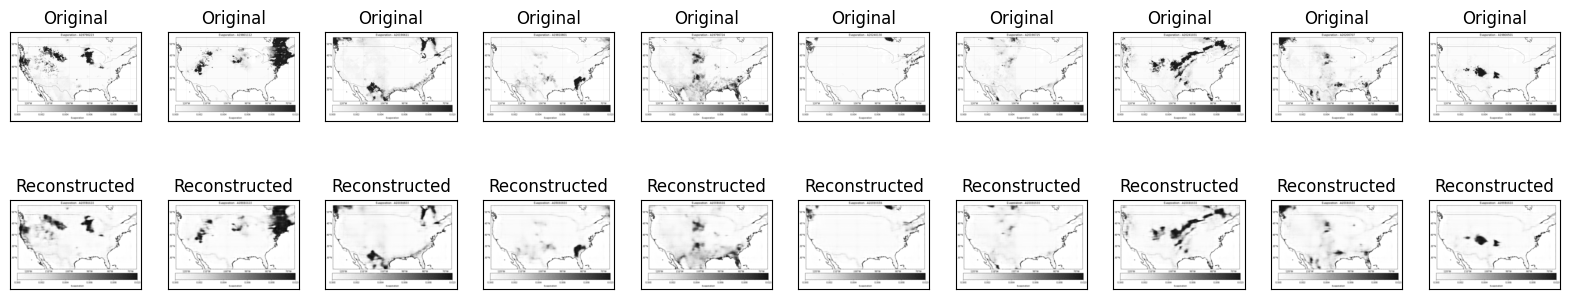

In [38]:
import matplotlib.pyplot as plt

def plot_reconstructions(images, n=10):
    reconstructed = autoencoder.predict(images[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_reconstructions(X_test)

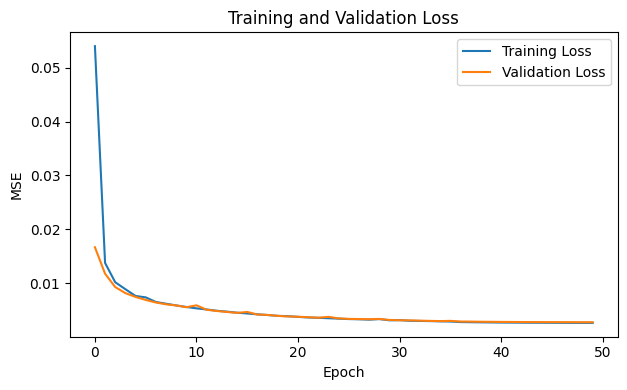

In [53]:

import matplotlib.pyplot as plt
import numpy as np

plt.close('all')        # Closes all open figures
plt.rcdefaults() 
# 5. Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

if 'lr' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()


In [ ]:

# 6. Visualize some reconstructions
print("Generating reconstructions...")
decoded_imgs = autoencoder.predict(X_test[:10], verbose=0)
visualize_reconstruction(X_test[:10], decoded_imgs)


In [ ]:
# import gc
# # Clear memory after training
# tf.keras.backend.clear_session()
# gc.collect()

In [40]:

# 7. Extract latent features (encoder output)

print("Extracting latent features...")
encoder = models.Model(autoencoder.input, autoencoder.layers[4].output)
encoded_features = encoder.predict(X, verbose=0)

# Get flattened features for clustering
features_flat = encoded_features.reshape(encoded_features.shape[0], -1)


Extracting latent features...


Detecting anomalies...


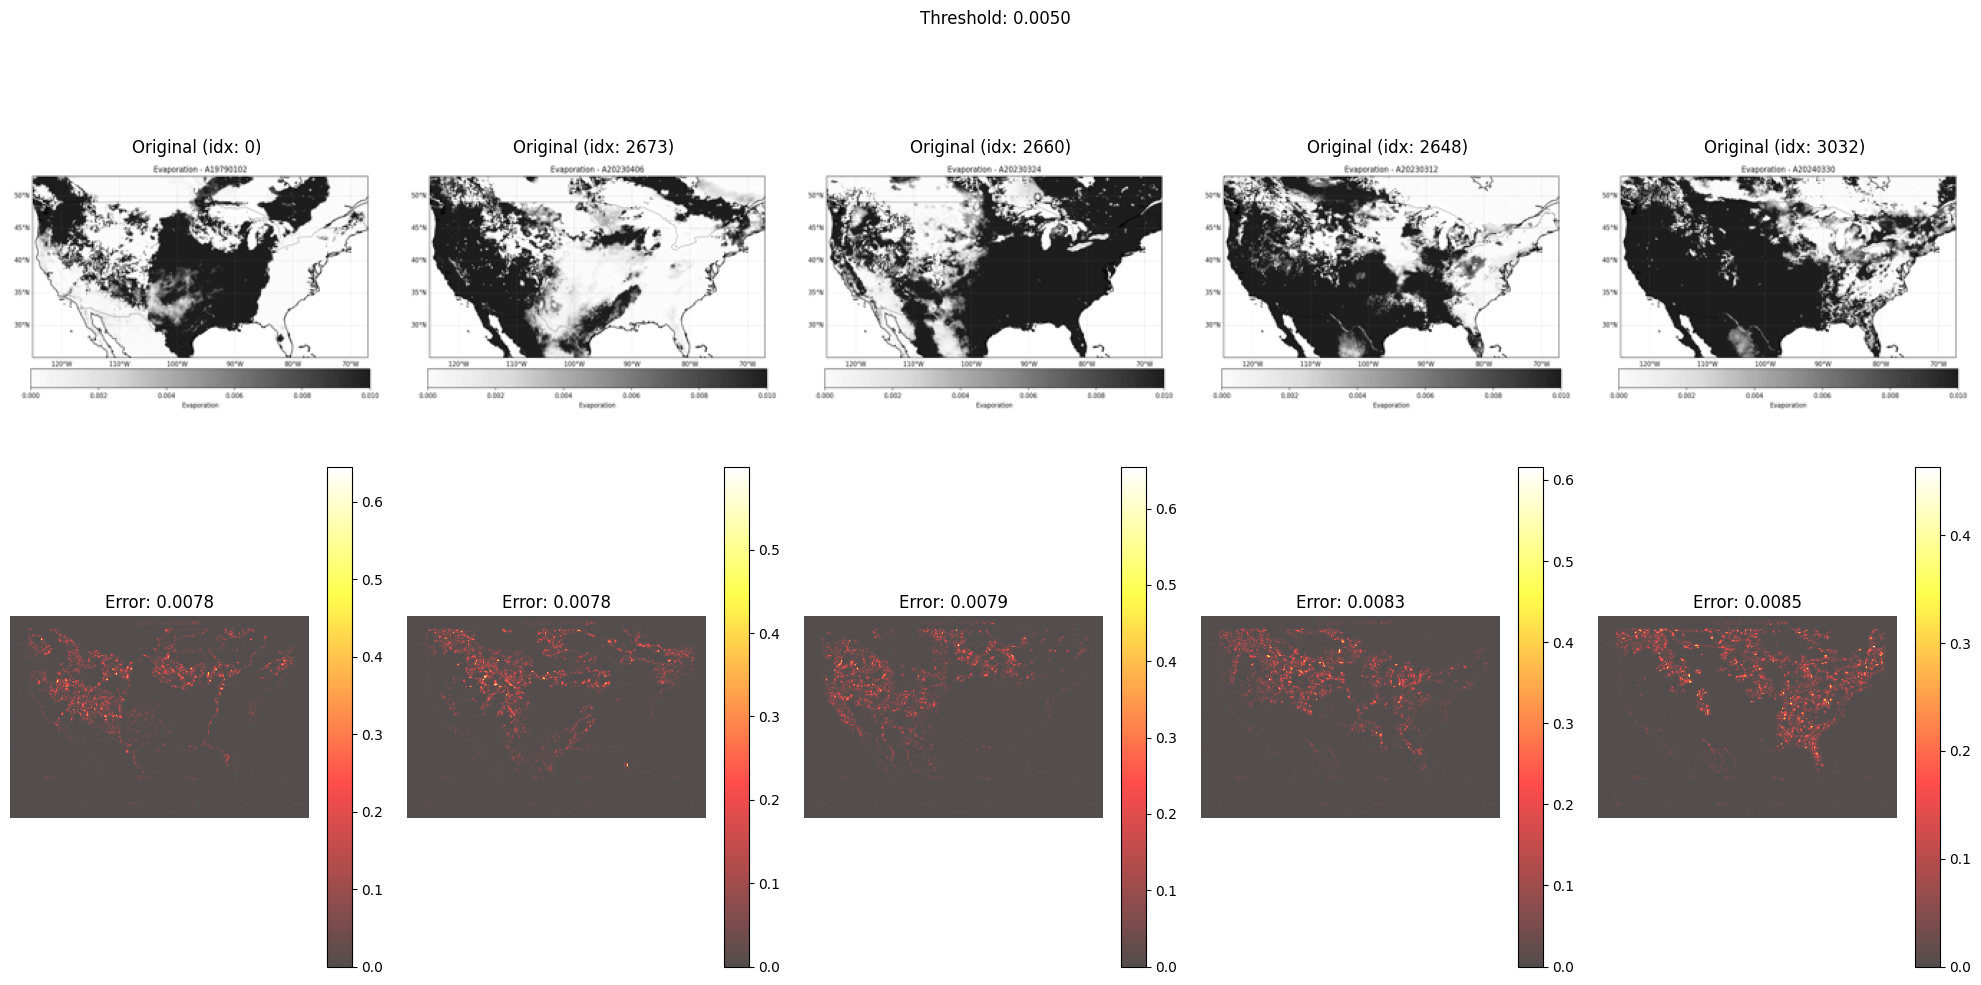

In [41]:

# 8. Detect anomalies
pixel_errors, image_errors, threshold = detect_anomalies(autoencoder, X)
visualize_anomalies(X, pixel_errors, image_errors, threshold)


In [42]:

# 9. Get anomalous indices
anomalous_indices = np.where(image_errors > threshold)[0]
print(f"Found {len(anomalous_indices)} potential drought areas")


Found 166 potential drought areas


In [56]:

# 10. Find optimal number of clusters (if we have enough anomalies)
if len(anomalous_indices) >= 10:
    optimal_k = 2#find_optimal_clusters(features_flat[anomalous_indices])
else:
    optimal_k = min(len(anomalous_indices), 2)
    print(f"Too few anomalies, using k={optimal_k}")


Clustering data into 2 clusters...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Performing t-SNE dimensionality reduction...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

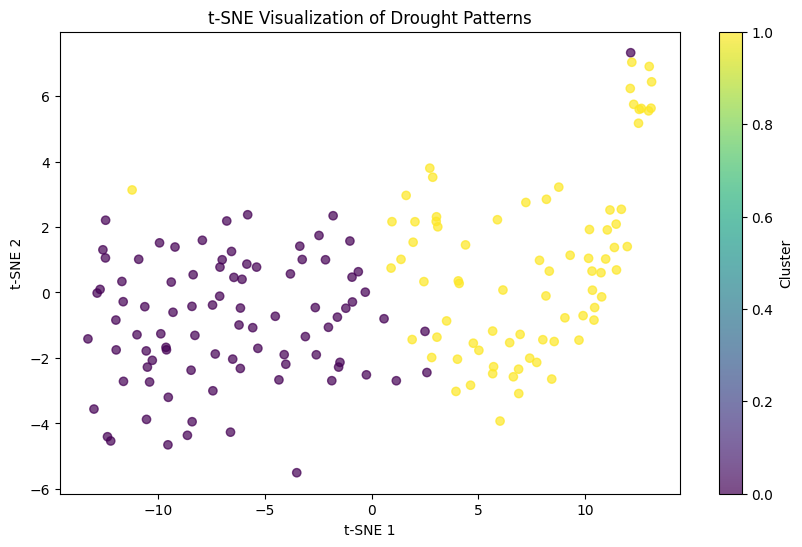

In [57]:

# 11. Cluster anomalies
anomalous_features = features_flat[anomalous_indices]
clusters = cluster_anomalies(anomalous_features, n_clusters=optimal_k)


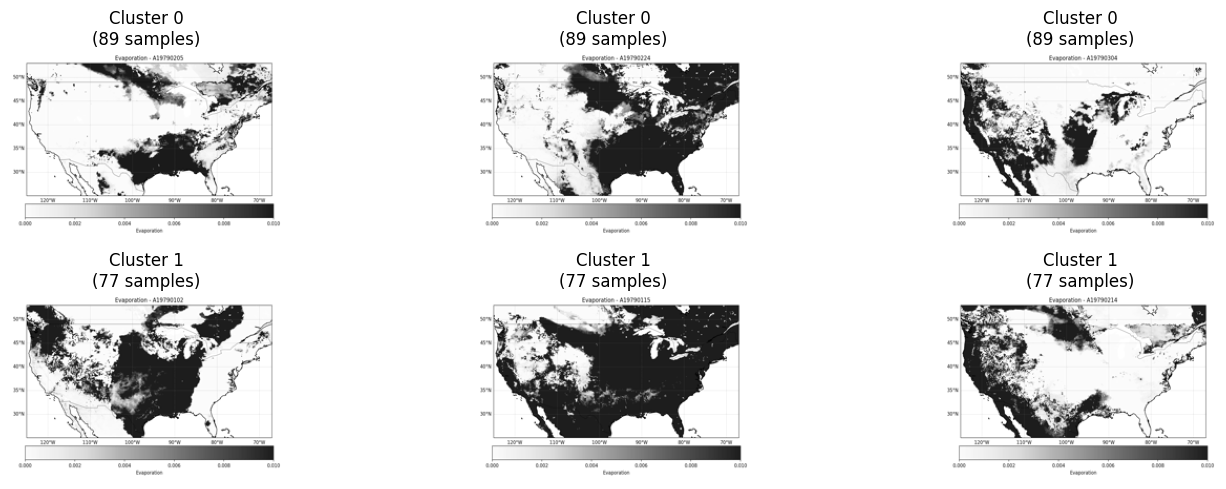

In [58]:

# 12. Visualize clusters
visualize_clusters(X, anomalous_indices, clusters)
